# LCPB 20-21 Exercise 3: CNN
## RandomGroup
### Alessandro Casalino 2015122
### Michele M. Crudele 2021858
### Sabrina Giorgetti 2013375
### Daniele Mellino 2013373


# Table of Contents

[Overview](#o)
1. [First Dataset](#1)
    1. [Confusion Matrix](#1.1)
2. [Changing the signal-to-noise ratio](#2)
3. [Second Dataset](#3)
4. [Study for different types of regularizations and lambda parameters](#4)


## Overview <a name="o"></a>

In this exercise we take into consideration the dataset "x_ts_L60_Z12_A500_DX50_bias5_N10000" which contains cuts of a time series obtained with the Markov chain. The labels, contained in the file "y_ts_L60_Z12_A500_DX50_bias5_N10000", are of three types: 

- Label 0 for a sample from the original time series
- Label 1 for a sample from the time series + positive external event
- Label 2 for a sample from the time series + negative external event

Defining a Convolutional Neural Network (CNN), and training it with our data, we want to identify the three different categories. 

In the first point, after training and fitting our model we visualize the confusion matrix.


In the second part we study the effect of the parameter A: A is the amplitute of the external signal in the data and by reducing it we reduce the signal-to-noise ratio. The signal-to-noise ratio is defined as the amplitute A with recpect to the step typical size DX of the jump process. 

From the confusion matrix we can see that for values of A smaller than 300 the network starts to fail discriminating the categories. 

In the third part we switch to a new set of data
"x_ts_comp_N10000.csv, y_ts_comp_N10000.csv": we perform an analysis with different models changing the number of convolutional layers, in particular from two to one, and dense layers. This with the global constrain of a network with at most 600 trainable parameters. 

In the fourth point we study the effect of different regularizations and lambda parameters to see if the performances improve. The three regularizations considered are:

- L1 LASSO
- L2 Ridge
- L1-L2 Mixed version

We perform a GridSearch on either the three regularizers and different lambda parameters: the best result is obtained for the LASSO regularizer with an intermediate value of lambda. We also display the weights of the filters of the first (convolutional) layer for different regularizers and values of lambda, noticing the different behaviours


In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numpy import random 
# Sequential =  normal neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
seed = 12345
import tensorflow as tf

if tf.__version__ == "1.14.0":
    tf.set_random_seed(seed)
else:
    tf.random.set_seed(seed)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## First Dataset  <a name="1"></a>

In this part we import our data ( x_ts_L60_Z12_A500_DX50_bias5_N10000, y_x_ts_L60_Z12_A500_DX50_bias5_N10000), define the Convolutional 
Neural Network and train it. Then we observe the performances of the accuracy and the loss function, together with the confusion matrix. 

10000


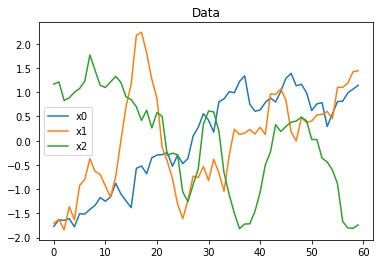

[1. 0. 0.]
10000 8000 2000 60


In [3]:
str0 = "ts_L60_Z12_A500_DX50_bias5_N10000"
#fnamex = "DATA/x_" + str0 + ".csv"
#fnamey = "DATA/y_" + str0 + ".csv"
fnamex="../content/drive/MyDrive/DATA/x_ts_L60_Z12_A500_DX50_bias5_N10000.csv"
fnamey="../content/drive/MyDrive/DATA/y_ts_L60_Z12_A500_DX50_bias5_N10000.csv"
x = np.loadtxt(fnamex, delimiter=",", dtype=float)
N = len(x)
print(N)

xm = x.mean(axis=1)
for n in range(N):
    x[n] = x[n] - xm[n]

std = x.std(axis=1)
for n in range(N):
    x[n] = x[n] / std[n]

plt.plot(x[0], label='x0')
plt.plot(x[1], label='x1')
plt.plot(x[2], label='x2')
plt.title('Data')
plt.legend()
plt.show()

categ = np.loadtxt(fnamey, delimiter=",", dtype=int)
N_categ = 3
y = np.zeros((N, N_categ))
for n in range(N):
    y[n][categ[n]] = 1.
print(y[0])

perc_train = 0.8
N_train = int(N * perc_train)

# In reality one has first to split x in (train+val) + test
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]

N_val = N - N_train
L = len(x[0])
print(N, N_train, N_val, L)

In [4]:
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val = x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

In [5]:
from keras import initializers, regularizers
# to use l1 and l2: regularizers.l1_l2(0.001, 0.02) (it is slower)
reg = regularizers.l1(0.005)
np.random.seed(12345)
# there's a way to let keras do it, we're only showing it from basics
ini = initializers.RandomNormal(mean=0, stddev=0.05)

model = Sequential()
model.add(Conv1D(filters=5, kernel_size=11,
                 kernel_regularizer=reg,
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                ))
model.add(AveragePooling1D(5))
model.add(Conv1D(filters=5, kernel_size=7, activation="relu"))
model.add(Flatten())
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(N_categ, activation="softmax"))

print(model.summary())

from keras import optimizers
# decay => learning rate dacays with epochs
opt = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-6)
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer="ADAM", metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [6]:
batch_size = 250
epochs = 300

fit = model.fit(x_train, y_train, 
                batch_size = batch_size, epochs=epochs,
                validation_data=(x_val, y_val),
               verbose=2, shuffle=True)

Epoch 1/300
32/32 - 3s - loss: 1.1048 - accuracy: 0.3535 - val_loss: 1.0970 - val_accuracy: 0.4055
Epoch 2/300
32/32 - 0s - loss: 1.0911 - accuracy: 0.4005 - val_loss: 1.0822 - val_accuracy: 0.4105
Epoch 3/300
32/32 - 0s - loss: 1.0746 - accuracy: 0.4159 - val_loss: 1.0632 - val_accuracy: 0.4425
Epoch 4/300
32/32 - 0s - loss: 1.0575 - accuracy: 0.4453 - val_loss: 1.0425 - val_accuracy: 0.4845
Epoch 5/300
32/32 - 0s - loss: 1.0358 - accuracy: 0.4666 - val_loss: 1.0204 - val_accuracy: 0.5085
Epoch 6/300
32/32 - 0s - loss: 1.0150 - accuracy: 0.4795 - val_loss: 0.9999 - val_accuracy: 0.5220
Epoch 7/300
32/32 - 0s - loss: 0.9944 - accuracy: 0.4972 - val_loss: 0.9785 - val_accuracy: 0.5190
Epoch 8/300
32/32 - 0s - loss: 0.9762 - accuracy: 0.5167 - val_loss: 0.9656 - val_accuracy: 0.5290
Epoch 9/300
32/32 - 0s - loss: 0.9647 - accuracy: 0.5142 - val_loss: 0.9476 - val_accuracy: 0.5510
Epoch 10/300
32/32 - 0s - loss: 0.9457 - accuracy: 0.5240 - val_loss: 0.9351 - val_accuracy: 0.5595
Epoch 11/

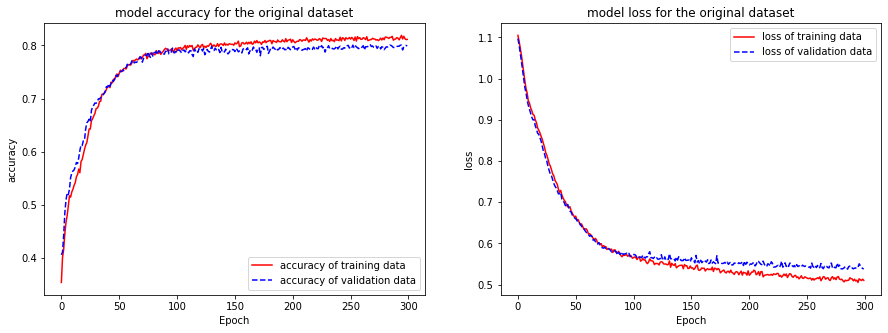

In [7]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

i=0
for obs in ('accuracy', 'loss'):
    axs[i].plot(fit.history[obs],'r', label=obs+ ' of training data')  
    axs[i].plot(fit.history['val_'+obs], 'b--', label=obs+' of validation data')
    axs[i].set_title('model ' + obs + " for the original dataset")
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel(obs)
    axs[i].legend()
    i +=1

 

### Confusion Matrix for the first Dataset<a name="1.1"></a>

Text(0.5, 15.0, 'True label')

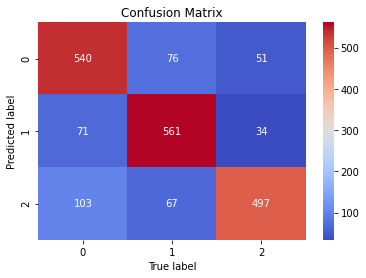

In [8]:
import seaborn
from sklearn import metrics

y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis = 1)
y_val_pred = np.argmax(y_val, axis = 1)
M = metrics.confusion_matrix(y_val_pred, y_pred, labels=[0,1,2])
M_norm = M / M.max()

cm = pd.DataFrame(M, index = [i for i in "012"],
                  columns = [i for i in "012"])
    
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm")
ax.set_title('Confusion Matrix')
ax.set_ylabel('Predicted label')
ax.set_xlabel('True label')


As we can see from the plot of the confusion matrix the predictions of the CNN are mostly correct.



### Weights of the filters of the first layer 

11
5


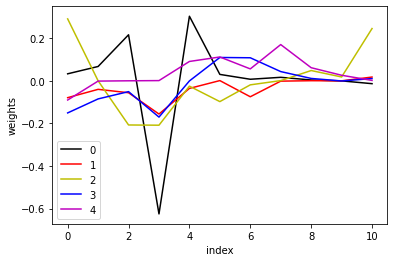

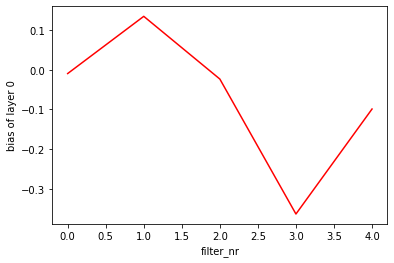

In [9]:
c = ['k','r','y','b','m']
def plot_w(w):
    plt.figure(figsize=(6,4))
    for i in range(len(w)):
        plt.plot(w[i][0], c[i], label=str(i))
    plt.xlabel('index')
    plt.ylabel('weights')
    plt.legend()
    plt.show()
    
w0 = model.layers[0].get_weights()[0]
w01 = model.layers[0].get_weights()[1]
w0T = w0.T
print(len(w0))
print(len(w0T))
plot_w(w0T)

plt.plot(w01, 'r')
plt.xlabel('filter_nr')
plt.ylabel('bias of layer 0')
plt.show()

# 2. Changing the signal-to-noise ratio <a name="2"></a>

In [10]:
df_cm={}
fit_dict={}
M={}


A_list=[50, 100, 150, 200, 250, 300, 350, 400, 450]

for A in A_list:
    str0 = f"ts_L60_Z12_A{A}_DX50_bias5_N10000"
    fnamex = "../content/drive/MyDrive/DATA/x_" + str0 + ".csv"
    fnamey = "../content/drive/MyDrive/DATA/y_" + str0 + ".csv"

    x = np.loadtxt(fnamex, delimiter=",", dtype=float)
    
    N = len(x)

    xm = x.mean(axis=1)
    for n in range(N):
        x[n] = x[n] - xm[n]

    std = x.std(axis=1)
    for n in range(N):
        x[n] = x[n] / std[n]

    #plt.figure()
    #plt.plot(x[0])
    #plt.plot(x[1])
    #plt.plot(x[2])
    #plt.show()

    categ = np.loadtxt(fnamey, delimiter=",", dtype=int)
    N_categ = 3
    y = np.zeros((N, N_categ))
    for n in range(N):
        y[n][categ[n]] = 1.
    
    
    perc_train = 0.8
    N_train = int(N * perc_train)

    # In reality one has first to split x in (train+val) + test
    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]

    N_val = N - N_train
    L = len(x[0])
    ##################################################
    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val = x_val.reshape(x_val.shape[0], L, 1)
    input_shape = (L, 1)
    ##################################################
    reg = regularizers.l1(0.005)
    np.random.seed(12345)
    # there's a way to let keras do it, we're only showing it from basics
    ini = initializers.RandomNormal(mean=0, stddev=0.05)

    model = Sequential()
    model.add(Conv1D(filters=5, kernel_size=11,
                     kernel_regularizer=reg,
                     kernel_initializer=ini,
                     activation="relu",
                     input_shape=input_shape
                    ))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(N_categ, activation="softmax"))

    #print(model.summary())
    # decay => learning rate dacays with epochs
    #opt = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-6)
    model.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer="ADAM", metrics=["accuracy"])
    ##################################################
    batch_size = 250
    epochs = 300
    
    fit_dict[A]= model.fit(x_train, y_train, 
                    batch_size = batch_size, epochs=epochs,
                    validation_data=(x_val, y_val),
                   verbose=2, shuffle=True)
    ####################################################
    
    y_pred = model.predict(x_val)
    y_pred = np.argmax(y_pred, axis = 1)
    y_val_pred = np.argmax(y_val, axis = 1)
    M[A]= metrics.confusion_matrix(y_val_pred, y_pred, labels=[0,1,2])
    #M_norm = M / M.max()

    import seaborn as sns
    import pandas as pd
    import matplotlib.pyplot as plt
    df_cm[A]= pd.DataFrame(M[A], index = [i for i in "012"],
                  columns = [i for i in "012"])
    
    #ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

Streaming output truncated to the last 5000 lines.
Epoch 201/300
32/32 - 0s - loss: 1.0987 - accuracy: 0.3332 - val_loss: 1.0986 - val_accuracy: 0.3335
Epoch 202/300
32/32 - 0s - loss: 1.0987 - accuracy: 0.3313 - val_loss: 1.0986 - val_accuracy: 0.3330
Epoch 203/300
32/32 - 0s - loss: 1.0987 - accuracy: 0.3293 - val_loss: 1.0986 - val_accuracy: 0.3335
Epoch 204/300
32/32 - 0s - loss: 1.0987 - accuracy: 0.3250 - val_loss: 1.0986 - val_accuracy: 0.3330
Epoch 205/300
32/32 - 0s - loss: 1.0987 - accuracy: 0.3306 - val_loss: 1.0986 - val_accuracy: 0.3335
Epoch 206/300
32/32 - 0s - loss: 1.0987 - accuracy: 0.3334 - val_loss: 1.0986 - val_accuracy: 0.3335
Epoch 207/300
32/32 - 0s - loss: 1.0987 - accuracy: 0.3334 - val_loss: 1.0986 - val_accuracy: 0.3335
Epoch 208/300
32/32 - 0s - loss: 1.0987 - accuracy: 0.3252 - val_loss: 1.0986 - val_accuracy: 0.3335
Epoch 209/300
32/32 - 0s - loss: 1.0987 - accuracy: 0.3273 - val_loss: 1.0986 - val_accuracy: 0.3335
Epoch 210/300
32/32 - 0s - loss: 1.0987 

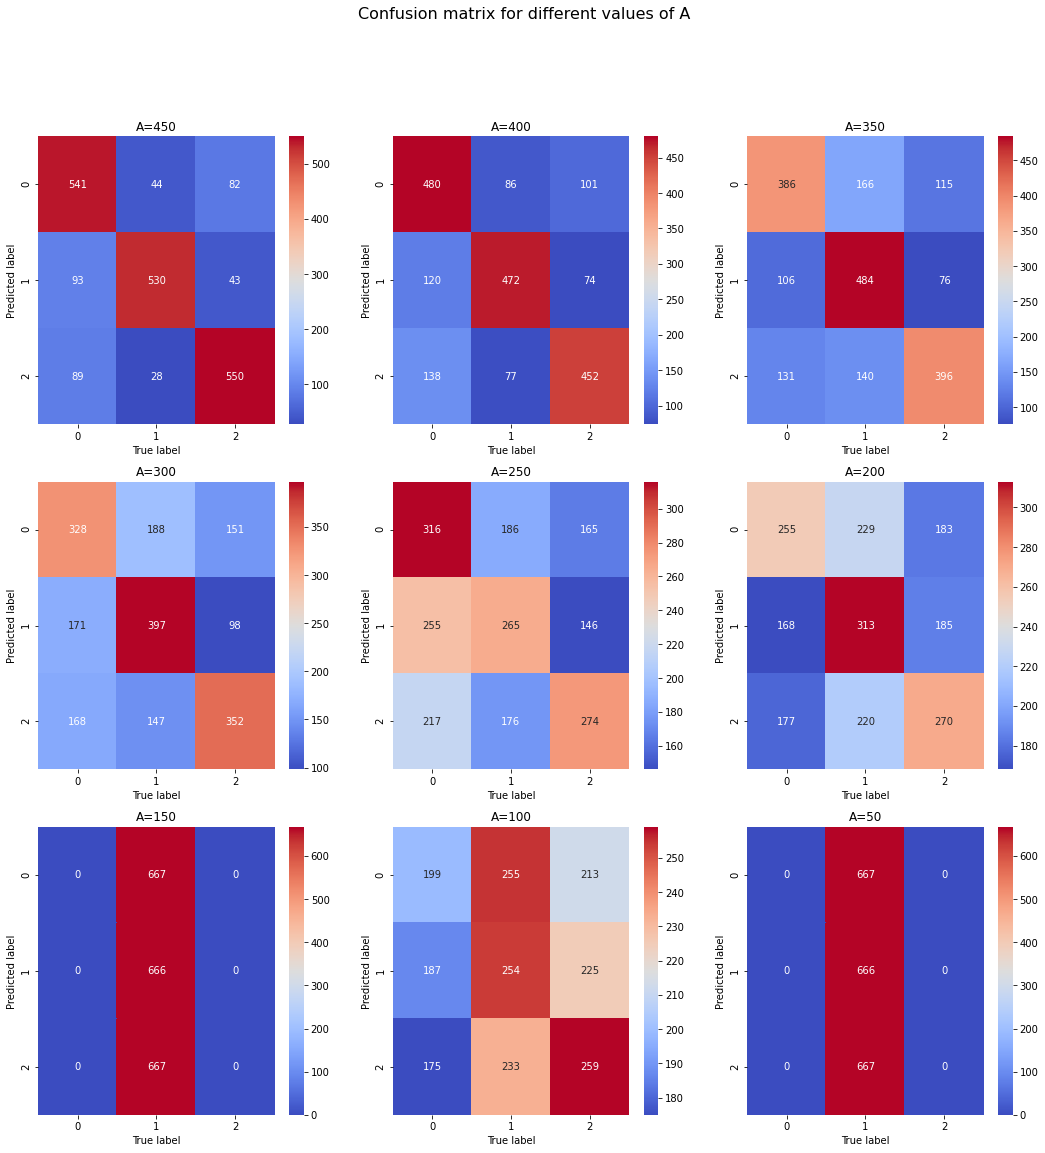

In [11]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(18,18))


sns.heatmap(df_cm[450], annot=True, fmt="d", cmap="coolwarm", ax=ax1)
ax1.set_title("A=450")
ax1.set_ylabel('Predicted label')
ax1.set_xlabel('True label')

sns.heatmap(df_cm[400], annot=True, fmt="d", cmap="coolwarm", ax=ax2)
ax2.set_title("A=400")
ax2.set_ylabel('Predicted label')
ax2.set_xlabel('True label')

sns.heatmap(df_cm[350], annot=True, fmt="d", cmap="coolwarm", ax=ax3)
ax3.set_title("A=350")
ax3.set_ylabel('Predicted label')
ax3.set_xlabel('True label')

sns.heatmap(df_cm[300], annot=True, fmt="d", cmap="coolwarm", ax=ax4)
ax4.set_title("A=300")
ax4.set_ylabel('Predicted label')
ax4.set_xlabel('True label')

sns.heatmap(df_cm[250], annot=True, fmt="d", cmap="coolwarm", ax=ax5)
ax5.set_title("A=250")
ax5.set_ylabel('Predicted label')
ax5.set_xlabel('True label')

sns.heatmap(df_cm[200], annot=True, fmt="d", cmap="coolwarm", ax=ax6)
ax6.set_title("A=200")
ax6.set_ylabel('Predicted label')
ax6.set_xlabel('True label')

sns.heatmap(df_cm[150], annot=True, fmt="d", cmap="coolwarm", ax=ax7)
ax7.set_title("A=150")
ax7.set_ylabel('Predicted label')
ax7.set_xlabel('True label')

sns.heatmap(df_cm[100], annot=True, fmt="d", cmap="coolwarm", ax=ax8)
ax8.set_title("A=100")
ax8.set_ylabel('Predicted label')
ax8.set_xlabel('True label')

sns.heatmap(df_cm[50], annot=True, fmt="d", cmap="coolwarm", ax=ax9)
ax9.set_title("A=50")
ax9.set_ylabel('Predicted label')
ax9.set_xlabel('True label')

fig.suptitle('Confusion matrix for different values of A', fontsize=16) 

plt.show()


# 3. Second dataset  <a name="3"></a>

We import the second dataset (x_ts_L60_Z12_A500_DX50_bias5_N10000,y_ts_L60_Z12_A500_DX50_bias5_N10000) and performe an analysis changing the number of convolutional layers and dense layers in the CNN. 



10000


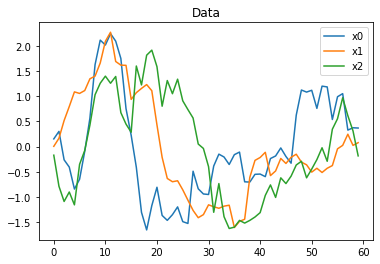

[0. 1. 0.]
10000 8000 2000 60


In [33]:
#str0 = "ts_L60_Z12_A500_DX50_bias5_N10000"

fnamex="../content/drive/MyDrive/DATA/x_ts_comp_N10000.csv"
fnamey="../content/drive/MyDrive/DATA/y_ts_comp_N10000.csv"
x = np.loadtxt(fnamex, delimiter=",", dtype=float)
N = len(x)
print(N)

xm = x.mean(axis=1)
for n in range(N):
    x[n] = x[n] - xm[n]

std = x.std(axis=1)
for n in range(N):
    x[n] = x[n] / std[n]

plt.plot(x[0], label='x0')
plt.plot(x[1], label='x1')
plt.plot(x[2], label='x2')
plt.title('Data')
plt.legend()
plt.show()


categ = np.loadtxt(fnamey, delimiter=",", dtype=int)
N_categ = 3
y = np.zeros((N, N_categ))
for n in range(N):
    y[n][categ[n]] = 1.
print(y[0])

perc_train = 0.8
N_train = int(N * perc_train)

# In reality one has first to split x in (train+val) + test
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]

N_val = N - N_train
L = len(x[0])
print(N, N_train, N_val, L)
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val = x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

In [13]:
from keras import initializers, regularizers
# to use l1 and l2: regularizers.l1_l2(0.001, 0.02) (it is slower)
reg1 = regularizers.l1(0.005)

def create_DNN(NCONV,reg=reg1):
    ini = keras.initializers.glorot_normal(seed=12345) #CHANGE #keras.initializers.RandomNormal(mean=0,stddev=0.05,seed=12345)

    model = Sequential()

    # Baiesi's CNN 
    if NCONV==1: 
        model.add(Conv1D(filters=5, kernel_size=11, kernel_initializer=ini,
                         kernel_regularizer = reg, 
                        activation='relu', input_shape=input_shape))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
        model.add(Flatten())
        model.add(Dense(10, activation='relu'))
        model.add(Dropout(0.2))

    # CNN with only one convolutional layer and with two dense layers 1
    if NCONV==2: 
        model.add(Conv1D(filters=5, kernel_size=11, 
                        kernel_initializer=ini,
                        kernel_regularizer = reg, 
                        activation='relu',
                        input_shape=input_shape))
        model.add(AveragePooling1D(5))
        model.add(Flatten())
        model.add(Dense(8, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dropout(0.2))
        
    # CNN with only one convolutional layer and with two dense layers 2
    if NCONV==3: 
        model.add(Conv1D(filters=5, kernel_size=15, #change kernel size in order to stay under 600 params
                        kernel_initializer=ini,
                        kernel_regularizer = reg, 
                        activation='relu',
                        input_shape=input_shape))
        model.add(AveragePooling1D(5))#max
        model.add(Flatten())
        model.add(Dense(9, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(7, activation='relu'))

    # CNN with one convolutional layers and  with three dense layers
    if NCONV==4: #0.90600
        model.add(Conv1D(filters=5, kernel_size=16,#<600 params
                        kernel_initializer=ini,
                        kernel_regularizer = reg, 
                        activation='relu',
                        input_shape=input_shape))
        model.add(AveragePooling1D(5))
        model.add(Flatten())
        model.add(Dense(8, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(6, activation='relu'))
        model.add(Dense(9, activation='relu'))
        
    model.add(Dense(N_categ, activation='softmax'))

    print(model.summary())
    return model


def compile_model(N,reg=reg1,optimizer="ADAM"):
    # create the mode
    model=create_DNN(N,reg=reg)
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model



In [14]:
from keras import optimizers 
#opt = optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True, decay=1e-6)
#opt = optimizers.RMSprop()
#opt = optimizers.Adam(learning_rate=0.009) 
#opt = optimizers.Nadam(learning_rate=0.009)


model1=compile_model(N=1)
model2=compile_model(N=2)
model3=compile_model(N=3)
model4=compile_model(N=4)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_10 (Averag (None, 10, 5)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 4, 5)              180       
_________________________________________________________________
flatten_10 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)               

In [15]:
np.random.seed(12345)

batch_size = 250
epochs = 300

fit1 = model1.fit(x_train, y_train, 
                batch_size = batch_size, epochs=epochs,
                validation_data=(x_val, y_val),
               verbose=0, shuffle=True) 

fit2 = model2.fit(x_train, y_train, 
                batch_size = batch_size, epochs=epochs,
                validation_data=(x_val, y_val),
               verbose=0, shuffle=True) 

fit3 = model3.fit(x_train, y_train, 
                batch_size = batch_size, epochs=epochs,
                validation_data=(x_val, y_val),
               verbose=0, shuffle=True) 

fit4 = model4.fit(x_train, y_train, 
                batch_size = batch_size, epochs=epochs,
                validation_data=(x_val, y_val),
               verbose=2, shuffle=True) 

Epoch 1/300
32/32 - 1s - loss: 1.1524 - accuracy: 0.3402 - val_loss: 1.1363 - val_accuracy: 0.3655
Epoch 2/300
32/32 - 0s - loss: 1.1337 - accuracy: 0.3708 - val_loss: 1.1288 - val_accuracy: 0.3950
Epoch 3/300
32/32 - 0s - loss: 1.1272 - accuracy: 0.3804 - val_loss: 1.1216 - val_accuracy: 0.4085
Epoch 4/300
32/32 - 0s - loss: 1.1196 - accuracy: 0.3925 - val_loss: 1.1133 - val_accuracy: 0.4210
Epoch 5/300
32/32 - 0s - loss: 1.1104 - accuracy: 0.4105 - val_loss: 1.1012 - val_accuracy: 0.4275
Epoch 6/300
32/32 - 0s - loss: 1.0974 - accuracy: 0.4187 - val_loss: 1.0837 - val_accuracy: 0.4490
Epoch 7/300
32/32 - 0s - loss: 1.0858 - accuracy: 0.4244 - val_loss: 1.0676 - val_accuracy: 0.4495
Epoch 8/300
32/32 - 0s - loss: 1.0702 - accuracy: 0.4314 - val_loss: 1.0520 - val_accuracy: 0.4590
Epoch 9/300
32/32 - 0s - loss: 1.0554 - accuracy: 0.4416 - val_loss: 1.0380 - val_accuracy: 0.4720
Epoch 10/300
32/32 - 0s - loss: 1.0450 - accuracy: 0.4493 - val_loss: 1.0232 - val_accuracy: 0.4790
Epoch 11/

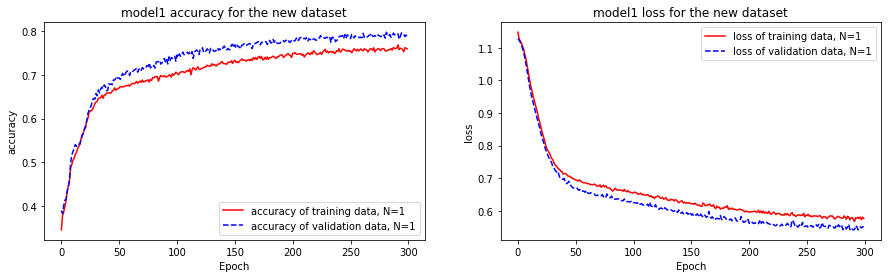

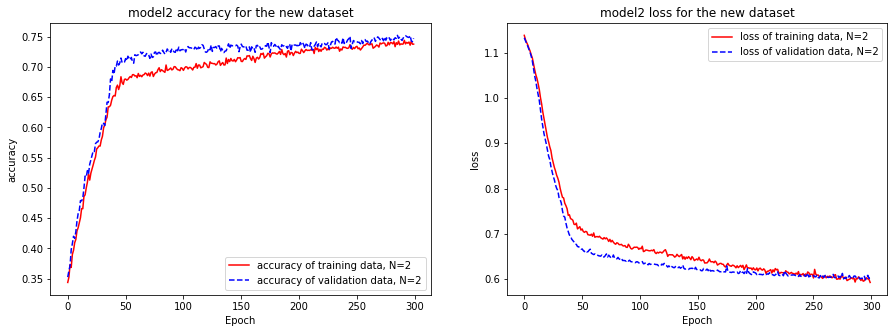

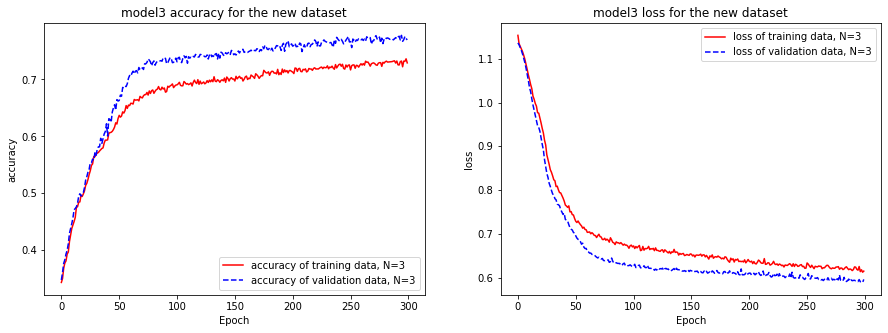

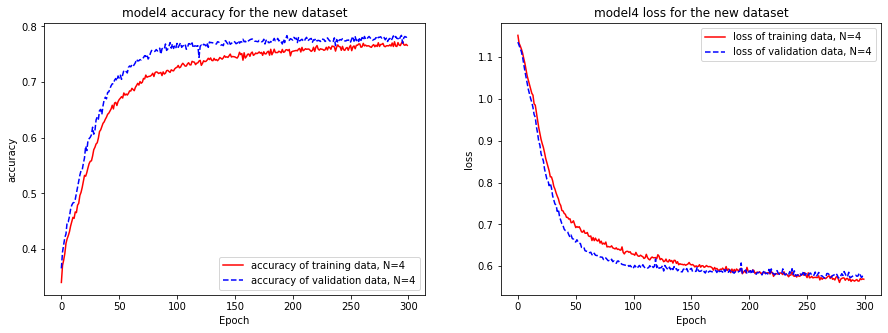

In [16]:
fig, axs = plt.subplots(1,2, figsize=(15, 4), facecolor='w', edgecolor='k')

i=0
for obs in ('accuracy', 'loss'):
    axs[i].plot(fit1.history[obs],'r', label=obs+ ' of training data, N=1')  
    axs[i].plot(fit1.history['val_'+obs], 'b--', label=obs+' of validation data, N=1')
    axs[i].set_title('model1 ' + obs + " for the new dataset")
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel(obs)
    axs[i].legend()
    i +=1


fig, axs2 = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

i=0
for obs in ('accuracy', 'loss'):
    axs2[i].plot(fit2.history[obs],'r', label=obs+ ' of training data, N=2')  
    axs2[i].plot(fit2.history['val_'+obs], 'b--', label=obs+' of validation data, N=2')
    axs2[i].set_title('model2 ' + obs + " for the new dataset")
    axs2[i].set_xlabel('Epoch')
    axs2[i].set_ylabel(obs)
    axs2[i].legend()
    i +=1

fig, axs3 = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

i=0
for obs in ('accuracy', 'loss'):
    axs3[i].plot(fit3.history[obs],'r', label=obs+ ' of training data, N=3')  
    axs3[i].plot(fit3.history['val_'+obs], 'b--', label=obs+' of validation data, N=3')
    axs3[i].set_title('model3 ' + obs + " for the new dataset")
    axs3[i].set_xlabel('Epoch')
    axs3[i].set_ylabel(obs)
    axs3[i].legend()
    i +=1

fig, axs4 = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

i=0
for obs in ('accuracy', 'loss'):
    axs4[i].plot(fit4.history[obs],'r', label=obs+ ' of training data, N=4')  
    axs4[i].plot(fit4.history['val_'+obs], 'b--', label=obs+' of validation data, N=4')
    axs4[i].set_title('model4 ' + obs + " for the new dataset")
    axs4[i].set_xlabel('Epoch')
    axs4[i].set_ylabel(obs)
    axs4[i].legend()
    i +=1

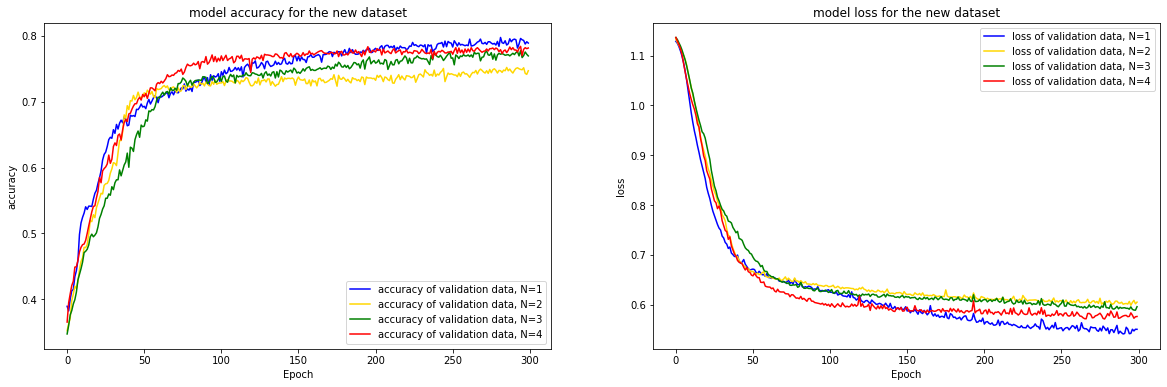

In [17]:
fig, axs = plt.subplots(1,2, figsize=(20, 6), facecolor='w', edgecolor='k')

i=0
for obs in ('accuracy', 'loss'):
    axs[i].plot(fit1.history['val_'+obs], 'b', label=obs+' of validation data, N=1')
    axs[i].set_title('model ' + obs + " for the new dataset")
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel(obs)

    axs[i].plot(fit2.history['val_'+obs], color='gold', label=obs+' of validation data, N=2')

    axs[i].plot(fit3.history['val_'+obs], 'g', label=obs+' of validation data, N=3')

    axs[i].plot(fit4.history['val_'+obs], 'r', label=obs+' of validation data, N=4')
    axs[i].legend()

    
      i +=1



We can see from the plots above that the highest accuracy is obtained with the first model (N=1). This is also confirmed by the confusion matrixes showed below.

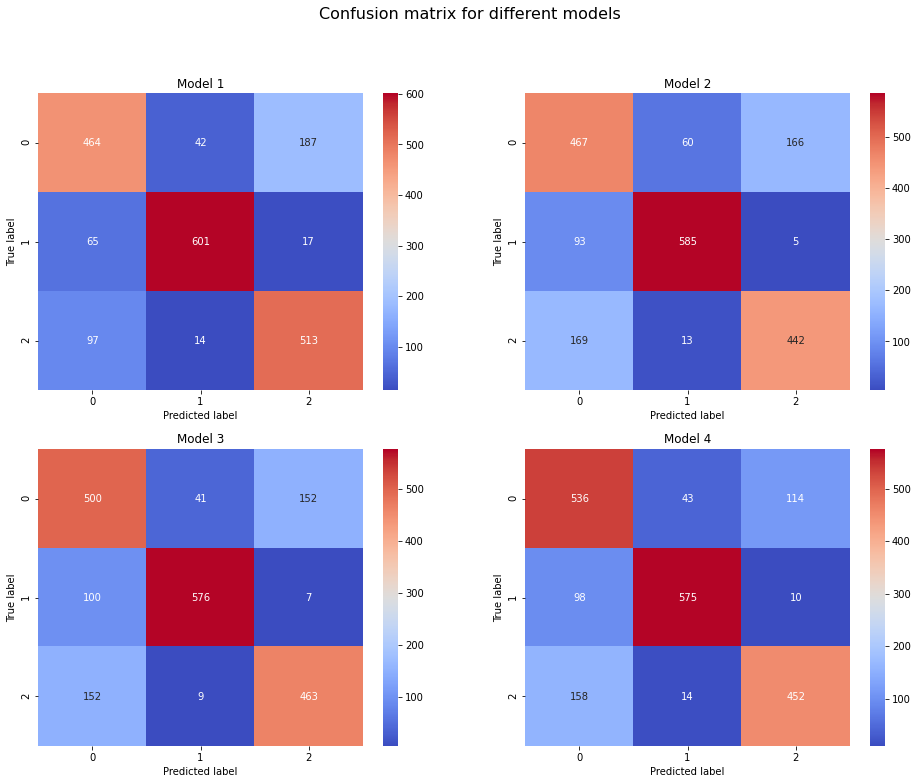

In [18]:
import seaborn
from sklearn import metrics
y_pred_list=[]
y_pred_list.append( model1.predict(x_val) )
y_pred_list.append( model2.predict(x_val) )
y_pred_list.append( model3.predict(x_val) )
y_pred_list.append( model4.predict(x_val) )


M_models=[]

for y_pred in y_pred_list:
    y_pred = np.argmax(y_pred, axis = 1)
    y_val_pred = np.argmax(y_val, axis = 1)
    M= metrics.confusion_matrix(y_val_pred, y_pred, labels=[0,1,2])
    #M_norm = M / M.max()

    M_models.append(M)


for i in range(len(M_models)):
      M_models[i]= pd.DataFrame(M_models[i], index = [i for i in "012"],
                  columns = [i for i in "012"])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,12))

sns.heatmap(M_models[0], annot=True, fmt="d", cmap="coolwarm", ax=ax1)
ax1.set_title("Model 1")
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

sns.heatmap(M_models[1], annot=True, fmt="d", cmap="coolwarm", ax=ax2)
ax2.set_title("Model 2")
ax2.set_xlabel('Predicted label')
ax2.set_ylabel('True label')

sns.heatmap(M_models[2], annot=True, fmt="d", cmap="coolwarm", ax=ax3)
ax3.set_title("Model 3")
ax3.set_xlabel('Predicted label')
ax3.set_ylabel('True label')

sns.heatmap(M_models[3], annot=True, fmt="d", cmap="coolwarm", ax=ax4)
ax4.set_title("Model 4")
ax4.set_xlabel('Predicted label')
ax4.set_ylabel('True label')

fig.suptitle('Confusion matrix for different models', fontsize=16) 

plt.show()


## Is the number of parameters scaling more quickly by adding Dense layers or Conv1D layers?

One of the main advantages of using CNN is the fact that the number of parameters to train is smaller with respect to the normal NN.
The number of parameter grows faster adopting Dense layers instead of Convolutional ones since for each dense layer of N neuron, we have to train order of $N^2$ parameters. 
In the models above we can see it in the summary table.

# 4. Study for different types of regularizations and lambda parameters <a name="4"></a>

We use the best model found in point 3 and perform a grid search on both the regularizer and the lambda parameter

In [19]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers

#reg = regularizers.l1()
#reg = regularizers.l2(lambda_val)
#reg = regularizers.l1_l2(lambda_val)
def compile_model( lambda_val,reg_type): 
    if reg_type==0:
        reg = regularizers.l1(lambda_val)
    if reg_type == 1:
        reg =regularizers.l2(lambda_val)
    if reg_type==2: 
        reg =regularizers.l1_l2(lambda_val)
    np.random.seed(12345)
    ini = keras.initializers.glorot_normal(seed=12345) #CHANGE #keras.initializers.RandomNormal(mean=0,stddev=0.05,seed=12345)
    # create the model
    model = Sequential()
    model.add(Conv1D(filters=5, kernel_size=11, kernel_initializer=ini,
                         kernel_regularizer = reg, 
                        activation='relu', input_shape=input_shape))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
        
    model.add(Dense(N_categ, activation='softmax'))
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer="adam",metrics=['accuracy'])
    return model

In [20]:
np.random.seed(12345)

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=300, 
                        batch_size=250, 
                        verbose=0)

# list of allowed optional arguments for the optimizer, see compile_model()
# lambda_val = [0., 1e-5, 1e-3, 1e-2, 1e-1]
lambda_val = [0., 1e-6, 1e-5, 1e-4, 1e-3]
reg_type=[0, 1, 2]

# define parameter dictionary
param_grid = dict(lambda_val=lambda_val,reg_type=reg_type )

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.771250 using {'lambda_val': 0.001, 'reg_type': 0}
0.736125 (0.019096) with: {'lambda_val': 0.0, 'reg_type': 0}
0.764500 (0.006344) with: {'lambda_val': 0.0, 'reg_type': 1}
0.756500 (0.026232) with: {'lambda_val': 0.0, 'reg_type': 2}
0.756125 (0.016505) with: {'lambda_val': 1e-06, 'reg_type': 0}
0.756875 (0.027362) with: {'lambda_val': 1e-06, 'reg_type': 1}
0.752750 (0.015686) with: {'lambda_val': 1e-06, 'reg_type': 2}
0.749125 (0.012007) with: {'lambda_val': 1e-05, 'reg_type': 0}
0.723250 (0.058498) with: {'lambda_val': 1e-05, 'reg_type': 1}
0.761500 (0.016632) with: {'lambda_val': 1e-05, 'reg_type': 2}
0.732375 (0.025540) with: {'lambda_val': 0.0001, 'reg_type': 0}
0.747875 (0.018078) with: {'lambda_val': 0.0001, 'reg_type': 1}
0.748375 (0.010621) with: {'lambda_val': 0.0001, 'reg_type': 2}
0.771250 (0.006300) with: {'lambda_val': 0.001, 'reg_type': 0}
0.735750 (0.023266) with: {'lambda_val': 0.001, 'reg_type': 1}
0.764875 (0.016253) with: {'lambda_val': 0.001, 'reg_type': 2}


In [28]:
print(grid_result.best_params_)
#model = compile_model(grid_result.best_params_ ['lambda_val'],grid_result.best_params_ ['reg_type'] )
#model = compile_model(*grid_result.best_params_.values() )

{'lambda_val': 0.001, 'reg_type': 0}


The best results are obtained for an intermediate value of lambda and the best regularization type is Lasso (l1)





In [38]:
np.random.seed(12345)

#l1-best: 'lambda_val': 0.001, 'reg_type': 0
model_l1 = compile_model(*grid_result.best_params_.values()) 

#compile to see the weights
#l2 : lambda_val': 1e-05, 'reg_type': 1
model_l2 = compile_model(1e-05,1) 

#compile to see the weights
#l1l2: 'lambda_val': 0.0001, 'reg_type': 2
model_l1l2 = compile_model(0.0001,2)


batch_size = 250
epochs = 300

fit_l1= model_l1.fit(x_train, y_train, 
                batch_size = batch_size, epochs=epochs,
                validation_data=(x_val, y_val),
               verbose=0, shuffle=True)

fit_l2= model_l2.fit(x_train, y_train, 
                batch_size = batch_size, epochs=epochs,
                validation_data=(x_val, y_val),
               verbose=0, shuffle=True) 

fit_l1l2= model_l1l2.fit(x_train, y_train, 
                batch_size = batch_size, epochs=epochs,
                validation_data=(x_val, y_val),
               verbose=0, shuffle=True) 

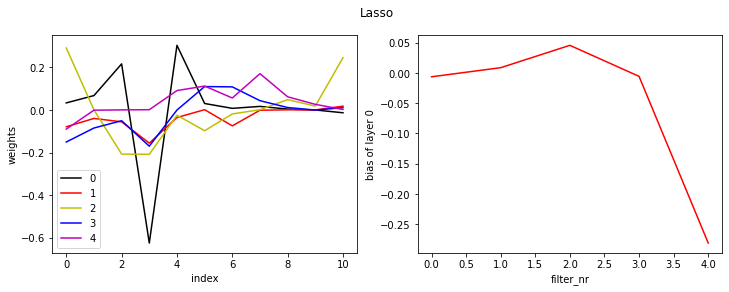

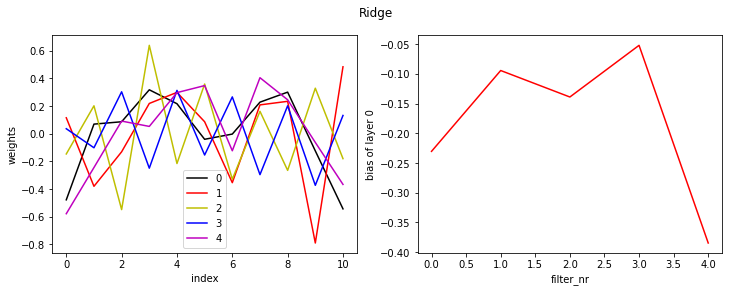

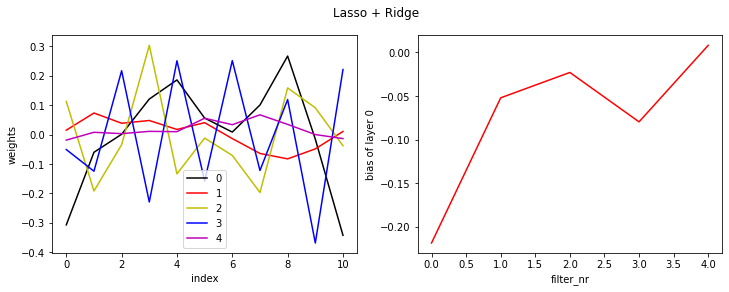

In [44]:
# Weights of the filters of the first layer
c = ['k','r','y','b','m']

def plot_w(w, axes):
    #plt.figure(figsize=(6,4))
    for i in range(len(w)):
        ax1.plot(w[i][0], c[i], label=str(i))
    ax1.set_xlabel('index')
    ax1.set_ylabel('weights')
    ax1.legend()

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4), facecolor='w', edgecolor='k')
fig.suptitle("Lasso")

w0_l1=model_l1.layers[0].get_weights()[0]
w01_l1=model_l1.layers[0].get_weights()[1]
w0T_l1=w0.T 


plot_w(w0T_l1, ax1)

ax2.plot(w01_l1, 'r')
ax2.set_xlabel('filter_nr')
ax2.set_ylabel('bias of layer 0')
plt.show()


##
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4), facecolor='w', edgecolor='k')
fig.suptitle("Ridge")

w0_l2=model_l2.layers[0].get_weights()[0]
w01_l2=model_l2.layers[0].get_weights()[1]
w0T_l2=w0_l2.T

plot_w(w0T_l2, ax1)

ax2.plot(w01_l2, 'r')
ax2.set_xlabel('filter_nr')
ax2.set_ylabel('bias of layer 0')
plt.show()

##
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4), facecolor='w', edgecolor='k')
fig.suptitle("Lasso + Ridge")

w0_l1l2=model_l1l2.layers[0].get_weights()[0]
w01_l1l2=model_l1l2.layers[0].get_weights()[1]
w0T_l1l2=w0_l1l2.T

plot_w(w0T_l1l2, ax1)

ax2.plot(w01_l1l2, 'r')
ax2.set_xlabel('filter_nr')
ax2.set_ylabel('bias of layer 0')
plt.show()

